<a href="https://colab.research.google.com/github/Value1965/Business_Up/blob/main/%D0%A1%D0%B8%D0%BC%D1%83%D0%BB%D1%8F%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Загрузим нужные библиотеки

In [1]:
!pip install catboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
#from catboost import CatboostClassifier
from catboost import CatBoostClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 30 kB/s 


## Подключим Google Disk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Загружаем датасеты

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/hacks_ai_2022/Дубна/train_dataset_train.csv")
df_user = pd.read_csv("/content/drive/MyDrive/hacks_ai_2022/Дубна/user_decision.csv")
df_user_data = pd.read_csv("/content/drive/MyDrive/hacks_ai_2022/Дубна/user.csv")
df_team_point = pd.read_csv("/content/drive/MyDrive/hacks_ai_2022/Дубна/team_point.csv")

## Рассмотрим датасет по ближе

## Обработка данных

In [4]:
df_team_point.head(30)

,team_id,category_id,period,score,place
0,1948,2,0,16,2
1,1934,3,4,45,6
2,1894,4,8,24,4
3,1688,4,0,27,4
4,1592,4,2,21,5
5,1344,5,0,8,6
6,1982,6,1,146,3
7,1460,2,2,-29,6
8,1492,2,1,8,3
9,1848,3,1,62,5


In [5]:
df_team_point['period_id']=df_team_point['period'].apply(lambda x: x+1)

In [6]:
if 'period' in df_team_point.columns:
  df_team_point.drop(['period'],axis=1,inplace=True)
df_team_point

,team_id,category_id,score,place,period_id
0,1948,2,16,2,1
1,1934,3,45,6,5
2,1894,4,24,4,9
3,1688,4,27,4,1
4,1592,4,21,5,3
...,...,...,...,...,...
10981,1312,4,32,4,2
10982,1974,1,4,6,1
10983,1822,1,31,1,5
10984,1390,2,16,2,1


In [7]:
df_user

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420
3,10236,2,284
4,10130,3,72
...,...,...,...
60223,10312,3,329
60224,10189,1,33
60225,10346,3,123
60226,10424,2,140


In [8]:
df_user_team = df_user.merge(df_user_data,on='user_id',how='left').sort_values('team_id')

df_user_team

,user_id,period,decision_id,team_id,game_id
31846,10762,2,105,1248,182
517,10273,2,135,1248,182
46978,10273,2,175,1248,182
4048,10762,2,66,1248,182
57683,10646,3,245,1248,182
...,...,...,...,...,...
52433,10316,3,91,1926,264
26527,10384,2,427,1926,264
34126,10022,3,92,1926,264
13139,10316,2,47,1926,264


In [9]:
df_user_team[df_user_team['team_id']==1366]

,user_id,period,decision_id,team_id,game_id
51822,10627,4,121,1366,192
20868,10001,1,168,1366,192
27850,10475,2,385,1366,192
6441,10475,1,408,1366,192
57372,10001,2,29,1366,192
...,...,...,...,...,...
8899,10001,2,32,1366,192
28255,10431,3,182,1366,192
26090,10627,2,269,1366,192
7769,10185,2,324,1366,192


In [10]:
df_user_team['period_id'] = df_user_team['period']
if 'period' in df_user_team.columns:
  df_user_team.drop(['period'],axis=1,inplace=True)
df_user_team

,user_id,decision_id,team_id,game_id,period_id
31846,10762,105,1248,182,2
517,10273,135,1248,182,2
46978,10273,175,1248,182,2
4048,10762,66,1248,182,2
57683,10646,245,1248,182,3
...,...,...,...,...,...
52433,10316,91,1926,264,3
26527,10384,427,1926,264,2
34126,10022,92,1926,264,3
13139,10316,47,1926,264,2


In [11]:
df_user_team_point = pd.merge(df_user_team,df_team_point,left_on=['team_id','period_id'],right_on=['team_id','period_id'],how='left')
df_user_team_point

,user_id,decision_id,team_id,game_id,period_id,category_id,score,place
0,10762,105,1248,182,2,6,261,1
1,10762,105,1248,182,2,3,98,6
2,10762,105,1248,182,2,5,20,1
3,10762,105,1248,182,2,2,68,1
4,10762,105,1248,182,2,1,27,1
...,...,...,...,...,...,...,...,...
361363,10022,316,1926,264,4,4,22,4
361364,10022,316,1926,264,4,1,7,5
361365,10022,316,1926,264,4,5,50,1
361366,10022,316,1926,264,4,3,61,5


In [12]:
df_user_point=df_user_team_point.groupby(['user_id','team_id'	,'period_id','category_id','score'],as_index=False).agg({'decision_id': 'count' })
df_user_point.rename(columns = {'decision_id' : 'decision_count'}, inplace = True) 
df_user_point

,user_id,team_id,period_id,category_id,score,decision_count
0,10001,1366,1,1,4,29
1,10001,1366,1,2,16,29
2,10001,1366,1,3,103,29
3,10001,1366,1,4,27,29
4,10001,1366,1,5,8,29
...,...,...,...,...,...,...
20035,10973,1372,4,2,-69,13
20036,10973,1372,4,3,39,13
20037,10973,1372,4,4,1,13
20038,10973,1372,4,5,29,13


In [13]:
df_team_score=df_user_point.groupby(['team_id',	'period_id','category_id'],as_index=False).agg({'decision_count': 'sum' })
df_team_score.rename(columns = {'decision_count' : 'decision_team'}, inplace = True) 
df_team_score

,team_id,period_id,category_id,decision_team
0,1248,1,1,43
1,1248,1,2,43
2,1248,1,3,43
3,1248,1,4,43
4,1248,1,5,43
...,...,...,...,...
5131,1926,4,2,129
5132,1926,4,3,129
5133,1926,4,4,129
5134,1926,4,5,129


In [14]:
df_user_point=pd.merge(df_user_point,df_team_score,how='left',left_on=['team_id','period_id','category_id'],right_on=['team_id','period_id','category_id'])

In [15]:
df_user_point

,user_id,team_id,period_id,category_id,score,decision_count,decision_team
0,10001,1366,1,1,4,29,69
1,10001,1366,1,2,16,29,69
2,10001,1366,1,3,103,29,69
3,10001,1366,1,4,27,29,69
4,10001,1366,1,5,8,29,69
...,...,...,...,...,...,...,...
20035,10973,1372,4,2,-69,13,68
20036,10973,1372,4,3,39,13,68
20037,10973,1372,4,4,1,13,68
20038,10973,1372,4,5,29,13,68


In [16]:
df_user_point.drop(['team_id'],axis=1,inplace=True)

In [17]:
df_user_point

,user_id,period_id,category_id,score,decision_count,decision_team
0,10001,1,1,4,29,69
1,10001,1,2,16,29,69
2,10001,1,3,103,29,69
3,10001,1,4,27,29,69
4,10001,1,5,8,29,69
...,...,...,...,...,...,...
20035,10973,4,2,-69,13,68
20036,10973,4,3,39,13,68
20037,10973,4,4,1,13,68
20038,10973,4,5,29,13,68


In [18]:
df_user_point['participation'] = df_user_point['decision_count']/df_user_point['decision_team']
df_user_point.head(30)

,user_id,period_id,category_id,score,decision_count,decision_team,participation
0,10001,1,1,4,29,69,0.420290
1,10001,1,2,16,29,69,0.420290
2,10001,1,3,103,29,69,0.420290
3,10001,1,4,27,29,69,0.420290
4,10001,1,5,8,29,69,0.420290
5,10001,1,6,158,29,69,0.420290
6,10001,2,1,32,23,127,0.181102
7,10001,2,2,79,23,127,0.181102
8,10001,2,3,107,23,127,0.181102
9,10001,2,4,59,23,127,0.181102


In [19]:
df_user_point=df_user_point.drop(['decision_count','decision_team'],axis=1).drop_duplicates()

In [20]:
df_user_point.head(30)

,user_id,period_id,category_id,score,participation
0,10001,1,1,4,0.420290
1,10001,1,2,16,0.420290
2,10001,1,3,103,0.420290
3,10001,1,4,27,0.420290
4,10001,1,5,8,0.420290
5,10001,1,6,158,0.420290
6,10001,2,1,32,0.181102
7,10001,2,2,79,0.181102
8,10001,2,3,107,0.181102
9,10001,2,4,59,0.181102


In [21]:
#df_user_point.loc[pd.IndexSlice[10001,4:4],:]

In [22]:
df_user_id=df_user_data['user_id'].to_numpy()
df_user_id

array([10189, 10018, 10580, 10600, 10112, 10610, 10352, 10131, 10636,
       10400, 10616, 10648, 10194, 10622, 10259, 10413, 10547, 10686,
       10723, 10583, 10833, 10696, 10839, 10086, 10124, 10520, 10017,
       10840, 10089, 10910, 10704, 10570, 10323, 10604, 10931, 10892,
       10150, 10191, 10870, 10279, 10609, 10118, 10501, 10374, 10507,
       10789, 10382, 10398, 10343, 10864, 10812, 10719, 10420, 10359,
       10882, 10538, 10525, 10288, 10193, 10179, 10100, 10114, 10061,
       10529, 10783, 10889, 10224, 10454, 10148, 10102, 10101, 10712,
       10526, 10304, 10823, 10209, 10428, 10309, 10943, 10731, 10117,
       10038, 10652, 10409, 10744, 10672, 10072, 10866, 10158, 10736,
       10724, 10096, 10051, 10746, 10185, 10868, 10395, 10536, 10002,
       10852, 10446, 10273, 10218, 10034, 10494, 10912, 10485, 10945,
       10236, 10676, 10453, 10574, 10523, 10445, 10504, 10080, 10790,
       10517, 10110, 10477, 10758, 10166, 10748, 10078, 10244, 10448,
       10602, 10264,

In [23]:
df_scores=pd.DataFrame({'user_id':df_user_id})

In [24]:
for category in range(1,7):
  for period in range(1,5):
    
    tmp_user_point = df_user_point[(df_user_point['category_id']==category)&(df_user_point['period_id']==period)] #
    index_pc = '_'+str(category)+'_'+str(period) #
    tmp_user_point['score'] = tmp_user_point['score'] * tmp_user_point['participation']
    tmp_user_point.rename(columns={'score' :'score'+index_pc},inplace=True) #,'score_team' :'score_team'+index_pc
    tmp_user_point.drop(['period_id','category_id','participation'],axis=1,inplace=True) #
    #print(tmp_user_point)
    df_scores=df_scores.merge(tmp_user_point,on='user_id',how='left')
      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
df_scores

,user_id,score_1_1,score_1_2,score_1_3,score_1_4,score_2_1,score_2_2,score_2_3,score_2_4,score_3_1,...,score_4_3,score_4_4,score_5_1,score_5_2,score_5_3,score_5_4,score_6_1,score_6_2,score_6_3,score_6_4
0,10189,2.545455,0.651163,2.054054,0.487179,10.181818,3.418605,8.729730,1.948718,65.545455,...,14.891892,16.076923,5.090909,1.302326,5.135135,5.358974,100.545455,27.674419,87.297297,73.564103
1,10018,NaN,0.157895,0.558140,0.209877,NaN,0.657895,1.500000,0.493827,NaN,...,1.081395,0.395062,NaN,0.342105,0.558140,0.234568,NaN,3.236842,6.348837,2.308642
2,10580,1.000000,0.486486,-0.069444,-0.516129,4.000000,2.027027,0.347222,-3.741935,25.750000,...,2.430556,1.161290,2.000000,0.648649,0.833333,2.451613,39.500000,14.432432,7.986111,5.677419
3,10600,0.500000,0.538462,-0.720721,0.882353,2.000000,1.884615,-1.549550,2.788235,12.875000,...,0.900901,1.764706,1.000000,0.423077,0.648649,0.917647,19.750000,8.192308,0.972973,8.258824
4,10112,0.146341,0.022556,0.133333,0.727273,0.585366,0.105263,0.226667,1.309091,3.768293,...,0.280000,0.945455,0.292683,0.105263,0.413333,1.454545,5.780488,1.000000,1.960000,6.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,10205,0.947368,0.384615,0.231405,NaN,3.789474,1.692308,1.851240,NaN,24.394737,...,2.545455,NaN,1.894737,0.923077,2.429752,NaN,37.421053,13.076923,14.694215,NaN
969,10325,0.206897,2.520000,2.173913,8.479167,0.827586,9.360000,4.565217,13.979167,5.327586,...,3.405797,10.083333,0.413793,2.340000,1.521739,7.333333,8.172414,39.240000,19.202899,57.750000
970,10527,1.090909,4.170213,3.260870,3.400000,4.363636,14.595745,12.681159,2.266667,28.090909,...,11.956522,14.166667,2.181818,3.276596,8.695652,19.833333,43.090909,65.234043,69.202899,74.800000
971,10371,2.000000,6.243243,13.134328,7.500000,8.000000,25.864865,32.835821,10.588235,51.500000,...,23.641791,11.470588,4.000000,7.135135,9.194030,11.470588,79.000000,163.216216,147.104478,71.911765


In [26]:
df_scores=df_scores.fillna(0.0)

In [27]:
#if 'decision_id' in df_user_team_point.columns:
#  df_user_team_point.drop(['decision_id','team_id','game_id','place'],axis=1,inplace=True)
#df_user_team_point

In [28]:
df_user_point_1 = df_user_point[df_user_team_point['period_id']==1].rename(columns = {'score' : 'score_1','score_team' : 'score_team_1'}).drop(['period_id'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [29]:
df_user_point_1

,user_id,category_id,score_1,participation
30,10002,1,43,0.252525
31,10002,2,83,0.252525
32,10002,3,107,0.252525
33,10002,4,53,0.252525
34,10002,5,13,0.252525
...,...,...,...,...
20035,10973,2,-69,0.191176
20036,10973,3,39,0.191176
20037,10973,4,1,0.191176
20038,10973,5,29,0.191176


In [30]:
df_user_point_2 = df_user_point[df_user_team_point['period_id']==2].rename(columns = {'score' : 'score_2','score_team' : 'score_team_2'}).drop(['period_id'],axis=1)
df_user_point_3 = df_user_point[df_user_team_point['period_id']==3].rename(columns = {'score' : 'score_3','score_team' : 'score_team_3'}).drop(['period_id'],axis=1)
df_user_point_4 = df_user_point[df_user_team_point['period_id']==4].rename(columns = {'score' : 'score_4','score_team' : 'score_team_4'}).drop(['period_id'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
if 'id' in df_train.columns:
  df_train.rename(columns={'id':'user_id'},inplace=True)
df_train

,user_id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
...,...,...,...,...,...
675,10563,5.0,4.0,5.0,4.0
676,10386,5.0,4.0,5.0,5.0
677,10675,5.0,4.0,5.0,4.0
678,10366,4.0,4.0,4.0,4.0


In [32]:
df_train_1 = df_train.merge(df_scores,on='user_id',how='left')

In [33]:
df_category=pd.DataFrame({'category_id':[1,2,3,4,5,6]})


In [34]:
df_train = df_train.merge(df_category,how='cross')

## Выделим выборки

In [35]:
#X = df_train.drop(["Analytical thinking",	"Systemic thinking",	"Adaptability",	"Focus"	,"user_id"], axis = 1)
#y = df_train[["Analytical thinking",	"Systemic thinking",	"Adaptability",	"Focus"]]
X = df_train_1.drop(["Analytical thinking",	"Systemic thinking",	"Adaptability",	"Focus"	,"user_id"], axis = 1)
y = df_train_1[["Analytical thinking",	"Systemic thinking",	"Adaptability",	"Focus"]]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X
y_train = y

## Обучение модели

In [37]:
y_train.to_numpy()[:,0]

array([4., 5., 6., 5., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 3., 3.,
       6., 4., 6., 4., 4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 5., 4., 4.,
       4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 5.,
       5., 4., 4., 3., 4., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 5., 3.,
       5., 5., 5., 4., 4., 4., 5., 5., 4., 5., 4., 5., 4., 5., 4., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 1., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 3., 4., 3.,
       4., 4., 5., 4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 4., 4., 5., 4.,
       4., 4., 5., 5., 4., 5., 4., 5., 4., 4., 5., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 5., 5., 6., 5., 5., 4., 4., 3., 5., 4., 4., 4.,
       5., 5., 5., 4., 4., 5., 5., 5., 4., 4., 4., 4., 5., 4., 4., 5., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 5., 4.,
       4., 4., 5., 4., 3., 5., 5., 4., 5., 4., 4., 6., 4., 4., 4., 4., 4.,
       5., 5., 5., 4., 5.

In [38]:
parameters={'depth':[6]}
def model_fit(model,X,Y):

  cv = GridSearchCV(model, param_grid=parameters, n_jobs=-1, scoring='recall', return_train_score=True) # ,
  cv.fit(X, Y) # , cat_features=cat_cols

  best_model = cv.best_estimator_
  print(cv.best_params_)

  print(cv.best_score_)

  for key in cv.cv_results_.keys():
    print(key,cv.cv_results_[key][cv.best_index_])

  cv_imp = pd.Series(best_model.get_feature_importance(),X.columns)
  fig, ax = plt.subplots(figsize=(16,14))
  cv_imp.plot.bar(ax=ax)
  ax.set_title("Важность признаков")
  ax.set_ylabel('Важность, %')
  fig.tight_layout()

  return cv

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan]
  category=UserWarning,


{'depth': 6}
nan
mean_fit_time 189.41774139404296
std_fit_time 42.52352022346468
mean_score_time 0.009482002258300782
std_score_time 0.0038043557077203343
param_depth 6
params {'depth': 6}
split0_test_score nan
split1_test_score nan
split2_test_score nan
split3_test_score nan
split4_test_score nan
mean_test_score nan
std_test_score nan
rank_test_score 1
split0_train_score nan
split1_train_score nan
split2_train_score nan
split3_train_score nan
split4_train_score nan
mean_train_score nan
std_train_score nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan]
  category=UserWarning,


{'depth': 6}
nan
mean_fit_time 176.43174595832824
std_fit_time 41.18024495605625
mean_score_time 0.007137870788574219
std_score_time 0.0023288823296646194
param_depth 6
params {'depth': 6}
split0_test_score nan
split1_test_score nan
split2_test_score nan
split3_test_score nan
split4_test_score nan
mean_test_score nan
std_test_score nan
rank_test_score 1
split0_train_score nan
split1_train_score nan
split2_train_score nan
split3_train_score nan
split4_train_score nan
mean_train_score nan
std_train_score nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan]
  category=UserWarning,


{'depth': 6}
nan
mean_fit_time 210.27006330490113
std_fit_time 57.82900581006291
mean_score_time 0.010394811630249023
std_score_time 0.0044586670398073115
param_depth 6
params {'depth': 6}
split0_test_score nan
split1_test_score nan
split2_test_score nan
split3_test_score nan
split4_test_score nan
mean_test_score nan
std_test_score nan
rank_test_score 1
split0_train_score nan
split1_train_score nan
split2_train_score nan
split3_train_score nan
split4_train_score nan
mean_train_score nan
std_train_score nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [nan]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [nan]
  category=UserWarning,


{'depth': 6}
nan
mean_fit_time 212.10455813407899
std_fit_time 56.02314008663096
mean_score_time 0.00891423225402832
std_score_time 0.005347509915402969
param_depth 6
params {'depth': 6}
split0_test_score nan
split1_test_score nan
split2_test_score nan
split3_test_score nan
split4_test_score nan
mean_test_score nan
std_test_score nan
rank_test_score 1
split0_train_score nan
split1_train_score nan
split2_train_score nan
split3_train_score nan
split4_train_score nan
mean_train_score nan
std_train_score nan


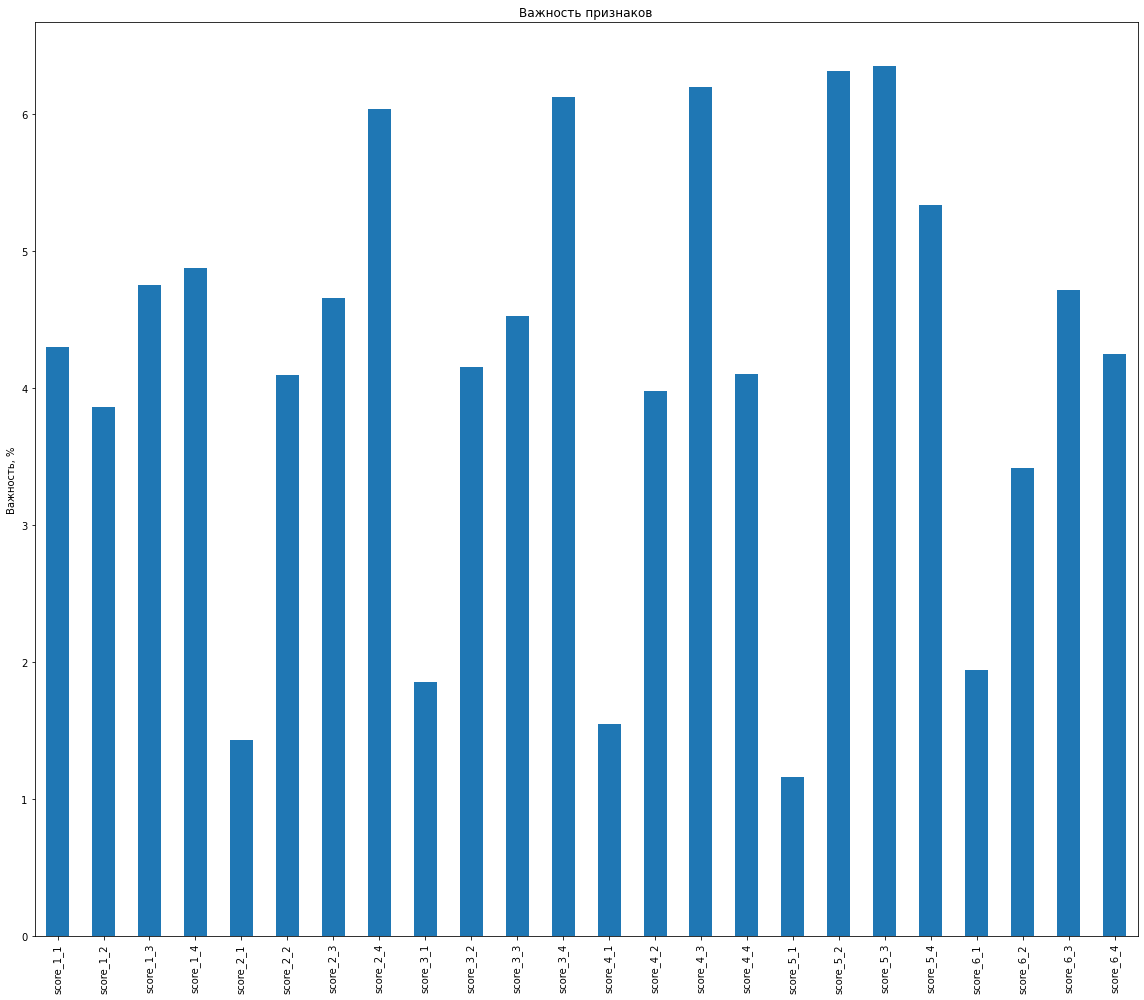

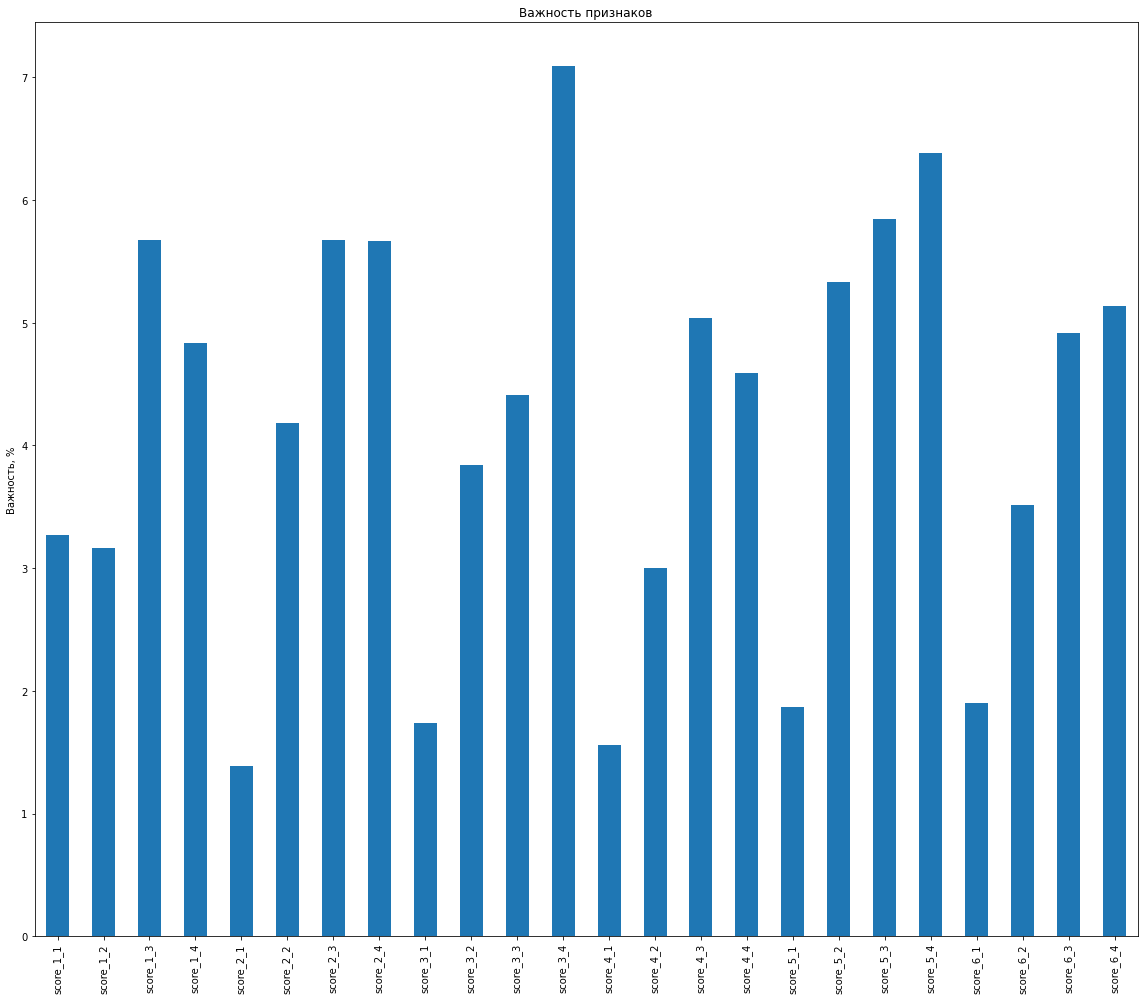

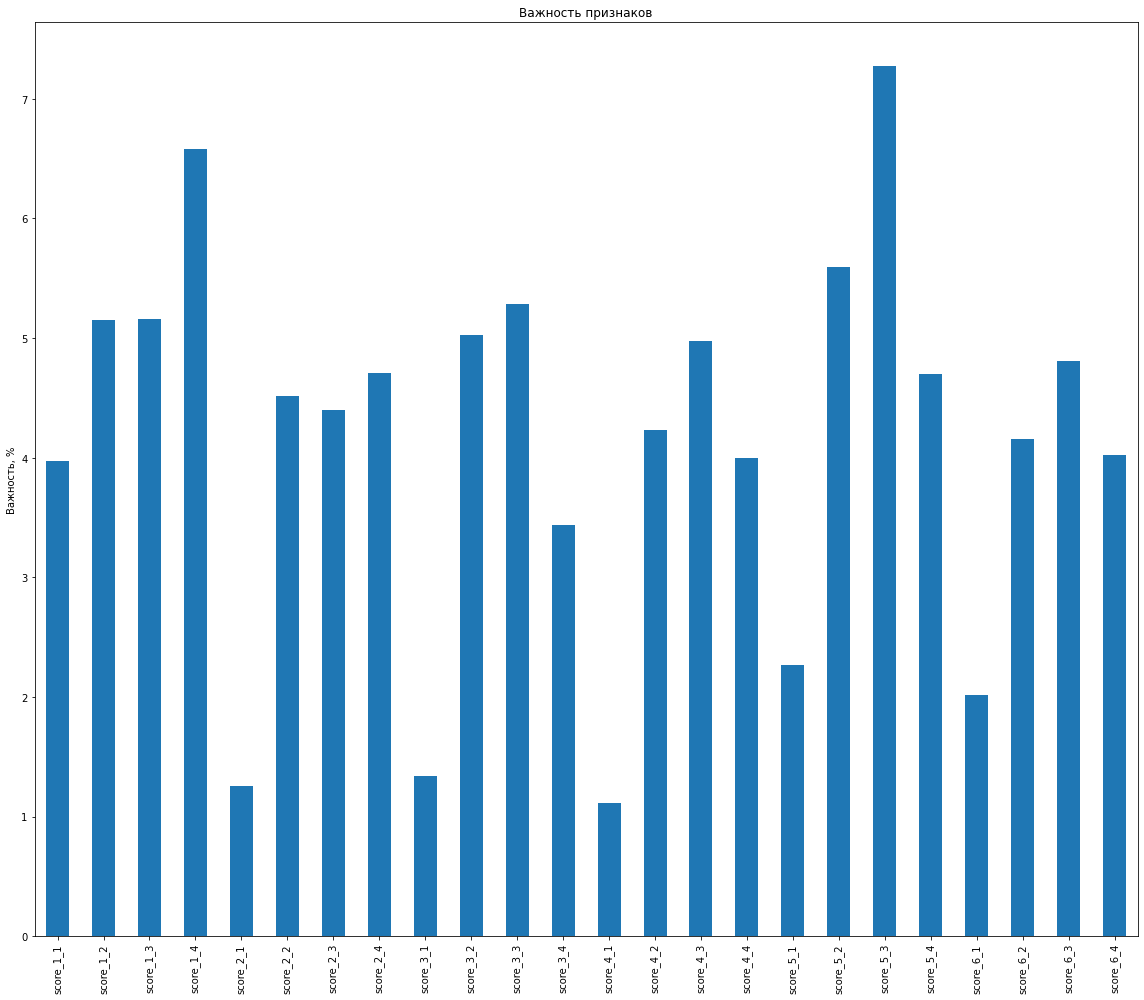

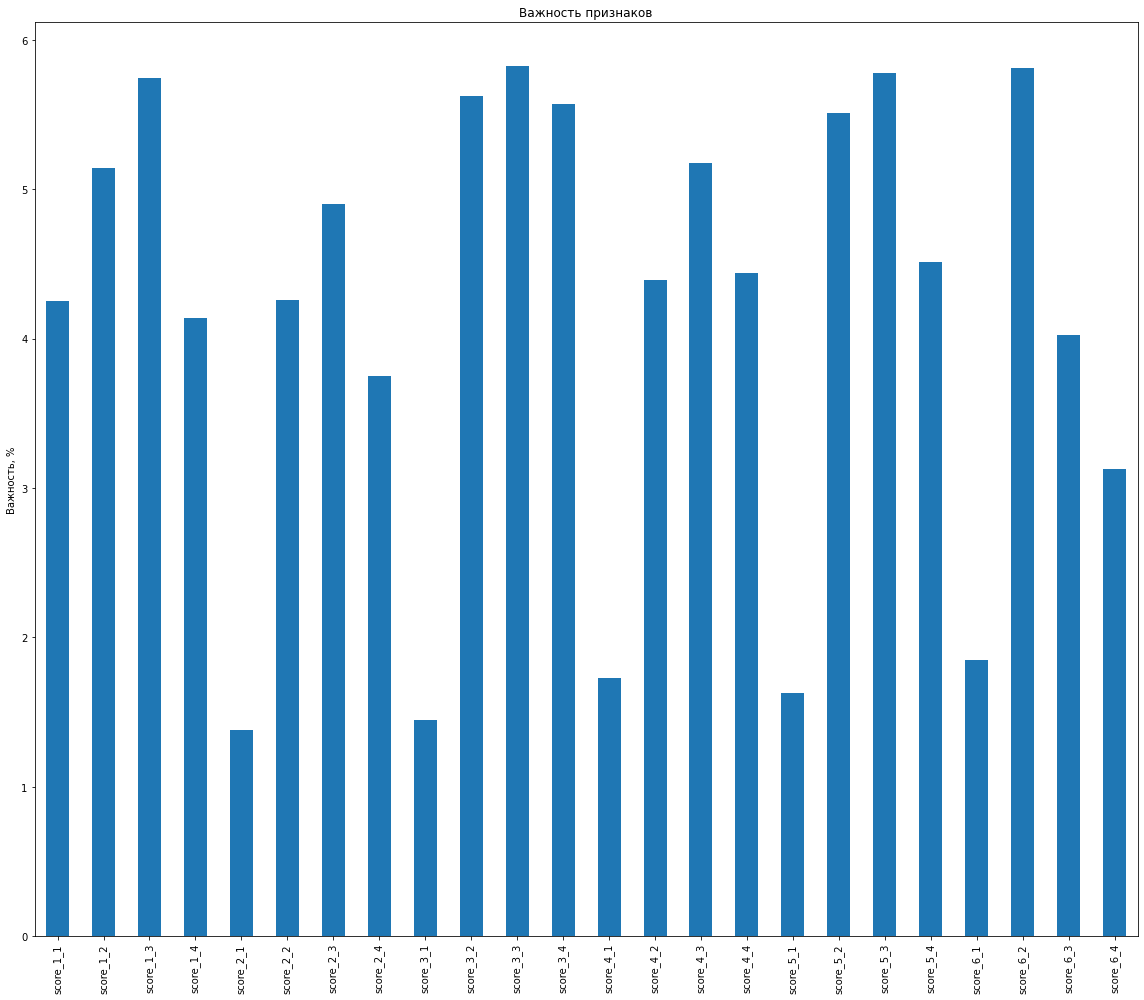

In [39]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

clf0 = CatBoostClassifier(random_state=0, boosting_type='Ordered', verbose = False)
cv0=model_fit(clf0, X_train, y_train.to_numpy()[:,0])

clf1 = CatBoostClassifier(random_state=0, boosting_type='Ordered', verbose = False)
cv1=model_fit(clf1, X_train, y_train.to_numpy()[:,1])

clf2 = CatBoostClassifier(random_state=0, boosting_type='Ordered', verbose = False) # auto_class_weights='Balanced',
cv2=model_fit(clf2, X_train, y_train.to_numpy()[:,2])

clf3 = CatBoostClassifier(random_state=0, boosting_type='Ordered', verbose = False)
cv3=model_fit(clf3, X_train, y_train.to_numpy()[:,3])


## Посчитаем скор

In [40]:
pred = clf.predict(X_test)

#pred0 = clf0.predict(X_test)
#pred1 = clf1.predict(X_test)
#pred2 = clf2.predict(X_test)
#pred3 = clf3.predict(X_test)

In [41]:
#pred = np.array([pred0,pred1,pred2,pred3]).transpose()[0]

In [42]:
result = 0 

for i in range(4):
  result += recall_score(y_test.to_numpy()[:,i], pred[:,i], average='macro', zero_division=True)

print("Recall score",result/4)

Recall score 1.0


In [43]:
X_test

,score_1_1,score_1_2,score_1_3,score_1_4,score_2_1,score_2_2,score_2_3,score_2_4,score_3_1,score_3_2,...,score_4_3,score_4_4,score_5_1,score_5_2,score_5_3,score_5_4,score_6_1,score_6_2,score_6_3,score_6_4
647,3.586207,10.920000,21.304348,28.520833,14.344828,40.560000,44.739130,47.020833,92.344828,74.880000,...,33.376812,33.916667,7.172414,10.140000,14.913043,24.666667,141.655172,170.040000,188.188406,194.250000
607,0.166667,-0.050000,-0.192771,0.729167,0.666667,-0.250000,-0.530120,1.197917,4.291667,3.300000,...,1.349398,1.979167,0.333333,0.700000,1.108434,1.875000,6.583333,5.350000,4.819277,9.322917
63,0.000000,0.000000,1.639344,0.000000,0.000000,0.000000,3.016393,0.000000,0.000000,0.000000,...,2.163934,0.000000,0.000000,0.000000,0.622951,0.000000,0.000000,0.000000,10.918033,0.000000
319,2.363636,2.048780,4.326733,-3.875000,9.454545,8.536585,10.930693,-13.175000,60.863636,26.292683,...,7.742574,5.812500,4.727273,4.097561,4.326733,12.400000,93.363636,50.878049,48.732673,24.412500
101,0.000000,3.082192,4.140845,4.856115,0.000000,10.273973,9.760563,10.489209,0.000000,36.643836,...,8.873239,6.992806,0.000000,3.424658,5.028169,6.410072,0.000000,65.068493,50.873239,40.597122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,3.000000,2.906977,-0.327273,-0.400000,12.000000,9.302326,0.000000,-0.400000,77.250000,41.860465,...,10.800000,6.200000,6.000000,7.558140,5.563636,4.400000,118.500000,76.744186,37.963636,24.600000
417,0.202532,0.601504,0.612903,1.151899,0.810127,1.917293,1.741935,0.974684,5.215190,4.022556,...,1.387097,2.746835,0.405063,0.488722,0.838710,3.721519,8.000000,8.759398,7.354839,14.531646
388,0.500000,-0.710526,-5.950000,8.380952,2.000000,-4.026316,-16.800000,26.285714,12.875000,23.210526,...,3.850000,19.428571,1.000000,2.131579,5.600000,7.619048,19.750000,27.236842,1.050000,98.285714
346,0.480000,0.265823,1.166667,1.018182,1.920000,0.974684,2.950980,2.545455,12.360000,5.848101,...,2.264706,1.927273,0.960000,0.974684,0.892157,1.090909,18.960000,9.924051,12.970588,9.090909


## Решение

In [44]:
df_sample = pd.read_csv("/content/drive/MyDrive/hacks_ai_2022/Дубна/sample_solution.csv")

if 'id' in df_sample.columns:
  df_sample.rename(columns={'id':'user_id'},inplace=True)

In [45]:
df_sample_1 = df_sample.merge(df_scores,on='user_id',how='left')

In [46]:
X_valid = df_sample_1.drop(["Analytical thinking",	"Systemic thinking",	"Adaptability",	"Focus"	,"user_id"], axis = 1)

In [47]:
pred_valid=clf.predict(X_valid)


pred0_valid = cv0.best_estimator_.predict(X_valid)
pred1_valid = cv1.best_estimator_.predict(X_valid)


pred2_valid = cv2.best_estimator_.predict(X_valid)
pred3_valid = cv3.best_estimator_.predict(X_valid)

In [48]:
pred_valid = np.array([pred0_valid,pred1_valid,pred2_valid,pred3_valid]).transpose()[0]

In [49]:
df_sample_1.rename(columns = {'user_id' : 'id'}, inplace = True) 

In [50]:
index=None
df_solution = pd.concat([df_sample_1['id'],pd.DataFrame(pred_valid,index,['Analytical thinking',	'Systemic thinking',	'Adaptability',	'Focus'])],axis=1).astype(int)

In [51]:
df_solution.to_csv('/content/drive/MyDrive/hacks_ai_2022/Дубна/my_submission.csv', sep=',', index=None)